## Dimensions of the Beam

In [1]:
import sympy as sp
import numpy as np
import matplotlib.pylab as plt
sp.init_printing()

In [2]:
b_w  = sp.Symbol('b_w', nonnegative = True)
d = sp.Symbol('d', nonnegative = True)
h = sp.Symbol('h', nonnegative = True)
f_c = sp.Symbol('f_c', nonnegative = True)
d_b =  sp.Symbol('d_b', nonnegative = True)
n = sp.Symbol('n', nonnegative = True)

In [3]:
params = {
    b_w : 75,#mm
    d : 230, #mm
    h : 250, #mm
    f_c : 37.9, #MPa
    d_b : 25.4, #mm
    n : 4, 
    h : 250, #mm
    
}

## Reinforcement Area

In [4]:
A_b = n * np.pi * d_b**2 / 4 #mm2
A_b.subs(params)

## fib Model Code 2010
In the case of monotonic loading, the reference $\tau_{b0}$ value of the bond stresses between concrete and reinforcing bar for pullout and splitting failure can be calculated as a function of the relative displacement $s$ parallel to the bar axis.
\begin{equation}
\tau_{b0} = \tau_{b\, max} \left(\frac{s}{s_1}\right)\,\, \mathrm{for}\,\,0\leq s \leq s_1 \\
\tau_{b0} = \tau_{b\, max} \,\, \mathrm{for}\,\,s_1 \leq s \leq s_2 \\
\tau_{b0} = \tau_{b\, max} - \left( \tau_{b\, max} - \tau_{bf} \left(\frac{s -s_2}{s_3 - s_2}\right) \right) \,\, \mathrm{for}\,\,s_2 \leq s \leq s_3 \\
\tau_{b0} = \tau_{bf} \,\, \mathrm{for}\,\,s_3 < s \\
\end{equation}
The parameters to be applied depend primarily on the failure mode i.e. Pullout or Splitting.
### Pullout
#### Good Bond Condition 
\begin{equation}
\tau_{b\,max} = 2.5 \sqrt{f_{c}} \,;\, s_1  = 1.00 \,;\, s_2 = 2.00 \,;\, s_3 = c_{clear} \,;\, \alpha = 0.4 \,;\, 
\tau_{bf} = 0.4 \tau_{bmax} \\
\end{equation}

In [5]:
s  = sp.Symbol('s', nonnegative = True)
s_1  = sp.Symbol('s_1', nonnegative = True)
s_2 = sp.Symbol('s_2', nonnegative = True)
s_3 = sp.Symbol('s_3', nonnegative = True)
alpha = sp.Symbol(r'\alpha', nonnegative = True)

In [6]:
tau_b_max = 2.5 * sp.sqrt(f_c)
tau_b_max

In [7]:
params_bm = {
    f_c : 37.9, #MPa
    s_1 : 1,
    s_2 : 2,
    s_3 : 4, ##c_clear = clear distance between ribs
    alpha : 0.4
}

In [8]:
tau_bf = 0.4 * tau_b_max
tau_bf

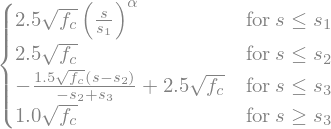

In [9]:
tau_b0 = sp.Piecewise(
    (tau_b_max * (s/s_1)**alpha,  s <= s_1),
    (tau_b_max ,  s <= s_2),
    (tau_b_max - ((tau_b_max - tau_bf)*(s - s_2)/(s_3 - s_2) ), s <= s_3),
    (tau_bf, s >= s_3)
)
tau_b0

In [10]:
get_tau_b0 = sp.lambdify((s), tau_b0.subs(params_bm), 'numpy')
get_tau_b0

<function _lambdifygenerated(s)>

No handles with labels found to put in legend.


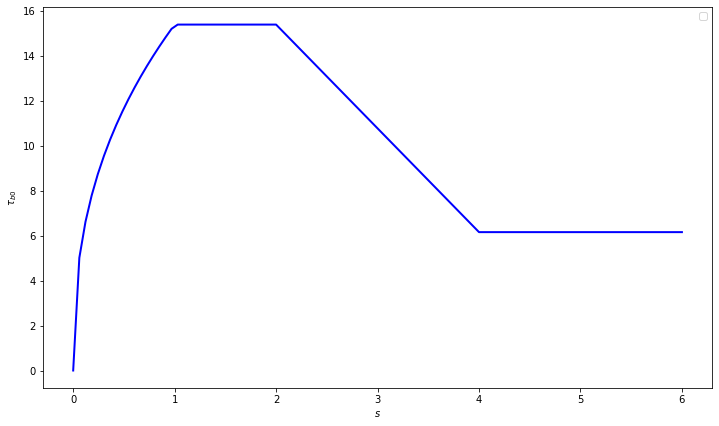

In [11]:
_, (ax1) = plt.subplots(1, 1, figsize=(12,7))
s_ = np.linspace(0, 6, 100)
tau_b0_val = get_tau_b0(s_)
ax1.plot(s_, tau_b0_val, color='blue', lw=2);
ax1.set_xlabel(r'$s$'); ax1.set_ylabel(r'$\tau_{b0}$')
ax1.legend()

## Dowel Action

### Baumann and Rusch Approach

According to Baumann and Rusch, the vertical displacement along the opening of the crack and the shear resistance resulting from dowel action is assumed to be linear elastic before the maximum shear force $V_{dmax}$ is reached. Thereafter, the shear resistance remains constant upon any further shear displacement. Therefore, the maximum shear force carried by dowel action is given as:
\begin{equation}
    V_{d\,max} =  1.64 b_n d_b f_c^{1/3}
    \label{eq: V_dmax}
\end{equation}
where, $b_n$ is the clear width of the beam $(b_w - n d_b)$. Here, $d_b, n, b_w$ represents diameter of bar, number of bars and width of beam respectively. 
\begin{equation}
    V_{da} =  V_{d\,max} \frac{\delta}{0.08}\,\mathrm{for\, \delta < 0.08 \,mm}
    \label{eq: V_daBR}
\end{equation}
where $\delta$ is vertical shear deformation.


In [12]:
delta = sp.Symbol('\delta', nonnegative = True)

In [13]:
b_n = b_w - n * d_b
b_n

In [14]:
V_d_max = 1.64 * b_n * d_b * f_c**(1/3)
V_d_max

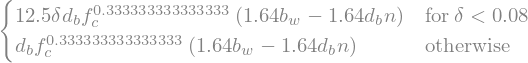

In [15]:
V_da_br = sp.Piecewise(
    (V_d_max * (delta/0.08), delta < 0.08),
    (V_d_max , delta >= 0.08)
    ) 
V_da_br 

In [16]:
get_V_da_br = sp.lambdify((delta), V_da_br.subs(params), 'numpy')
get_V_da_br

<function _lambdifygenerated(Dummy_166)>

<img src="fig/dowel_fig_baumann.png" width="800"/>

#### Martin's Approach for calculating $V_{da}$ and $\delta_k$
Peak force for pre-peak and ductile post peak dowel deformation is calculated as:
\begin{equation}
    V_{da} =  V_{d\,max} \frac{\delta}{0.05}\left(2 - \frac{\delta}{0.05}\right)\,\mathrm{for\, \delta \leq 0.05 \,mm}
    \label{eq: V_da1}
\end{equation}
\begin{equation}
    V_{da} =  V_{d\,max} \frac{2.55 - \delta}{2.5}\,\mathrm{for \,\delta > 0.05 \,mm}
    \label{eq: V_da2}
\end{equation}
where $\delta$ is vertical shear deformation and is given as(SCPT):
\begin{equation}
    \delta = \varphi \left(\frac{y_1}{\tan{\beta_1}} + \frac{ y_2 }{\tan{\beta_2}} \right) 
    \label{eq: deltak}
\end{equation}
$\varphi, \beta_{1,2}, y_{1,2}$ rotation of center of rotation of shear crack, angles of the cracks and length of the cracks in vertical coordinates.

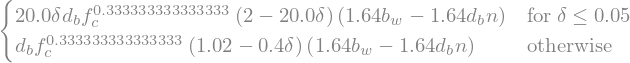

In [17]:
V_da = sp.Piecewise(
    (V_d_max * (delta/0.05) * (2 - (delta/0.05)), delta <= 0.05),
    (V_d_max * ((2.55 - delta) / 2.5), delta > 0.05)
    ) 
V_da

In [18]:
get_V_da = sp.lambdify((delta), V_da.subs(params), 'numpy')
get_V_da

<function _lambdifygenerated(Dummy_167)>

No handles with labels found to put in legend.


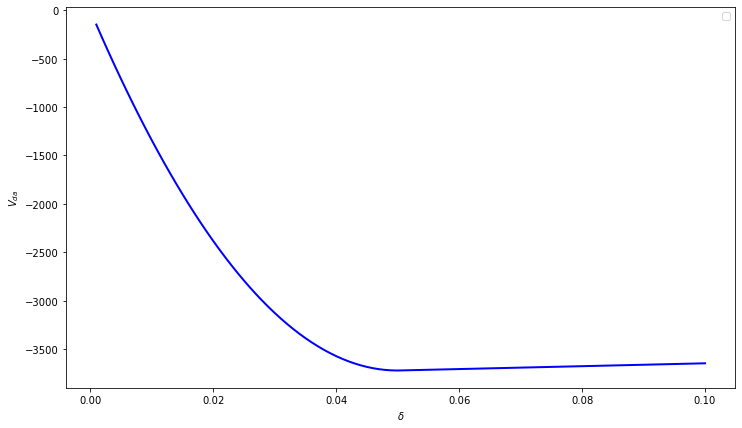

In [21]:
_, (ax1) = plt.subplots(1, 1, figsize=(12,7))
delta_ = np.linspace(0.001, 0.1, 100)
V_da_val = get_V_da(delta_)
ax1.plot(delta_, V_da_val, color='blue', lw=2);
ax1.set_xlabel(r'$\delta$'); ax1.set_ylabel(r'$V_{da}$')
ax1.legend()

## Aggregate Interlock

### Bazant's Approach refined by Gambarova
The Rough Crack Model proposed by Bazant was later refined by Gambarova in which he modified the relationship between normal stresses $\sigma_{ag}$ and crack kinematics (w and s). He further stated that the aggregate size $d_g$ plays a greater role in transferring shear. The stress can be transferred according to the following equations:
\begin{equation}
\sigma_{ag} = -0.62 \sqrt{w} \frac{r}{(1 + r^2)^{0.25}} \tau_{ag} \\
\tau_{ag} = \tau_0 \left( 1 - \sqrt{\frac{2 w}{d_g}}\right) r \frac{a_3 + a_4 \|r\|^3}{1 + a_4 r^4}
\end{equation}
where,
\begin{equation}
r = \frac{\delta}{w} \\
\tau_0 = 0.25 f_c \\
a_3 = \frac{2.45}{\tau_0} \\
a_4 = 2.44 \left( 1 - \frac{4}{\tau_0}\right)
\end{equation}

<img src="fig/aggregate_interlock.png" width="800"/>

In [22]:
w = sp.Symbol('w', nonnegative = True)
d_g  = sp.Symbol('d_g', nonnegative = True)

In [23]:
r = delta/w
r

In [24]:
tau_0 = 0.25 * f_c
tau_0

In [25]:
a_3  =  2.45/tau_0
a_3

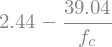

In [26]:
a_4  = 2.44 * (1 - (4/tau_0))
a_4

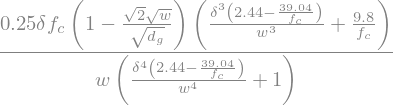

In [27]:
tau_ag = tau_0 * (1 - sp.sqrt((2 * w)/d_g)) * r * (a_3 + (a_4 * sp.Abs(r)**3)) / (1 + (a_4 *r**4))
tau_ag

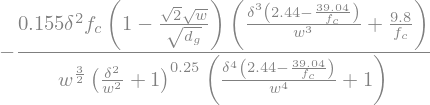

In [28]:
sigma_ag = -0.62 * sp.sqrt(w) * (r)/(1 + r**2)**0.25 * tau_ag
sigma_ag

In [29]:
params_ag = {
    f_c : 37.9, #MPa
    d_g : 22, ##mm
}

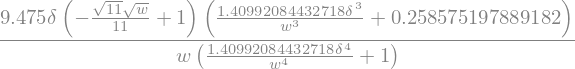

In [30]:
get_tau_ag = sp.lambdify((w, delta), tau_ag.subs(params_ag), 'numpy')
tau_ag.subs(params_ag)

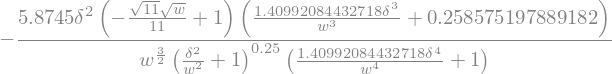

In [31]:
get_sigma_ag = sp.lambdify((w, delta), sigma_ag.subs(params_ag), 'numpy')
sigma_ag.subs(params_ag)

In [32]:
w_ = np.linspace(0.1, 1, 3)
tau_ag = np.zeros((100,3))
for i, w in enumerate(w_):
    delta_ = np.linspace(0.001, 1, 100)
    for j, delta in enumerate(delta_):
        tau_ag[j,i] = get_tau_ag(w, delta)
#print(tau_ag);

In [33]:
w_ = np.linspace(0.1, 1, 3)
sigma_ag = np.zeros((100,3))
for i, w in enumerate(w_):
    delta_ = np.linspace(0.001, 1, 100)
    for j, delta in enumerate(delta_):
        sigma_ag[j,i] = get_sigma_ag(w, delta)
#print(sigma_ag)

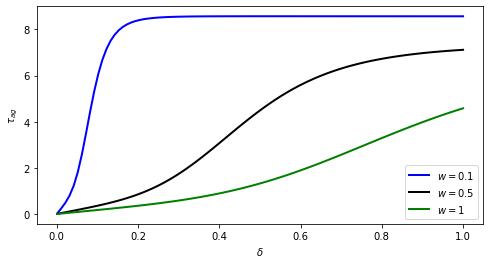

In [34]:
_, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.plot(delta_, tau_ag[:,0], color='blue', lw=2, label = (r'$w = 0.1$'))
ax1.plot(delta_, tau_ag[:,1], color='black', lw=2, label = (r'$w = 0.5$'))
ax1.plot(delta_, tau_ag[:,2], color='green', lw=2, label = (r'$w = 1$'))
ax1.set_xlabel(r'$\delta$'); ax1.set_ylabel(r'$\tau_{ag}$')
ax1.legend()

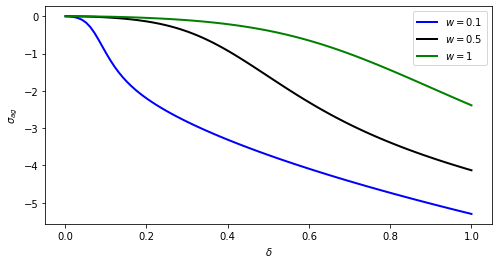

In [35]:
_, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.plot(delta_, sigma_ag[:,0], color='blue', lw=2, label = (r'$w = 0.1$'))
ax1.plot(delta_, sigma_ag[:,1], color='black', lw=2, label = (r'$w = 0.5$'))
ax1.plot(delta_, sigma_ag[:,2], color='green', lw=2, label = (r'$w = 1$'))
ax1.set_xlabel(r'$\delta$'); ax1.set_ylabel(r'$\sigma_{ag}$')
ax1.legend()